In [1]:
import sys
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
import matplotlib.pyplot as plt
from PySide6.QtWidgets import QApplication
from temgymbasic.gui import TemGymWindow

import numpy as np
from temgymbasic.utils import calculate_phi_0
from temgymbasic import gbd

from typing import Tuple, NamedTuple
from temgymbasic.plotting import plot_model
%matplotlib ipympl

In [13]:
def zero_phase(u, idx_x, idx_y):
    u_centre = u[idx_x, idx_y]
    phase_difference =  0 - np.angle(u_centre)
    u = u * np.exp(1j * phase_difference)
    
    return u

def make_detector_for_gauss_rays(x_det, y_det, n_rays):
    x,y = np.meshgrid(x_det, y_det)
    
    r = np.array([x.ravel(), y.ravel()]).T
    r = np.broadcast_to(r, [n_rays, *r.shape])
    r = np.swapaxes(r, 0, 1)

    return r

def abssqr(x):
    return np.real(x*np.conj(x))

def FT(x):
    return np.fft.fftshift(np.fft.fft2(x))

def iFT(x):
    return np.fft.ifft2(np.fft.ifftshift(x))
    
def FresnelPropagator(E0, ps, lambda0, z):
    """
    Parameters:
        E0 : 2D array
            The initial complex field in the x-y source plane.
        ps : float
            Pixel size in the object plane (same units as wavelength).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        z : float
            Propagation distance (in the same units as ps).

    Returns:
        Ef : 2D array
            The complex field after propagating a distance z.
    """
    n, m = E0.shape

    fx = np.fft.fftfreq(n, ps)
    fy = np.fft.fftfreq(m, ps)
    Fx, Fy = np.meshgrid(fx, fy)
    
    H = np.exp(-1j * (2 * np.pi / lambda0) * z) * np.exp(-1j * np.pi * lambda0 * z * (Fx**2 + Fy**2))
    E0fft = np.fft.fft2(E0)
    G = H * E0fft
    Ef = np.fft.ifft2(G)
    
    return Ef

def lens_phase_factor(n, ps, lambda0, f):
    """
    Compute the phase factor introduced by an ideal lens.
    
    Parameters:
        n : int
            Number of pixels (assuming square grid, n x n).
        ps : float
            Pixel size (in the same units as wavelength and focal length).
        lambda0 : float
            Wavelength of the light (in the same units as ps).
        f : float
            focal length of the lens (in the same units as ps).
    
    Returns:
        phase_factor : 2D array (n x n)
            The phase factor to multiply with the field.
    """
    x = np.linspace(-n/2, n/2 - 1, n) * ps
    y = np.linspace(-n/2, n/2 - 1, n) * ps
    X, Y = np.meshgrid(x, y)
    
    phase_factor = np.exp(-1j * np.pi * (X**2 + Y**2) / (lambda0 * f) + 1j * np.pi)
    
    return phase_factor

In [14]:
n_rays = 1
wavelength = 0.1
k = 2 * np.pi / wavelength

wavelengths = np.full(n_rays, wavelength)
a = 20
focal = 10
b = 20

size = 1000
det_shape = (size, size)
pixel_size = 10 / size
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)

wo = 0.4
wos = np.full(n_rays, wo)

div = wavelength / (np.pi * wo)

dPx = wo
dPy = wo
dHx = div
dHy = div

z_r = (np.pi * wo ** 2) / wavelengths 

theta_x = -0
theta_y = 0

deg_yx = np.deg2rad((theta_y, theta_x ))
tilt_yx = np.tan(deg_yx)

x0 = 1.25
y0 = 0

In [15]:
components = (
    comp.GaussBeam(
        z=0.0,
        voltage=calculate_phi_0(wavelength),
        radius=x0,
        wo=wo,
        tilt_yx=tilt_yx
    ),
    comp.Lens(
        z = a,
        f = focal,
    ),
    comp.AccumulatingDetector(
        z=a + b,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=64,
    ),
)

In [16]:
model = Model(components)
rays = tuple(model.run_iter(num_rays=n_rays))
image = model.detector.get_image(rays[-1])
det_x = np.linspace(-det_shape[1]//2*pixel_size, det_shape[1]//2*pixel_size, det_shape[1])

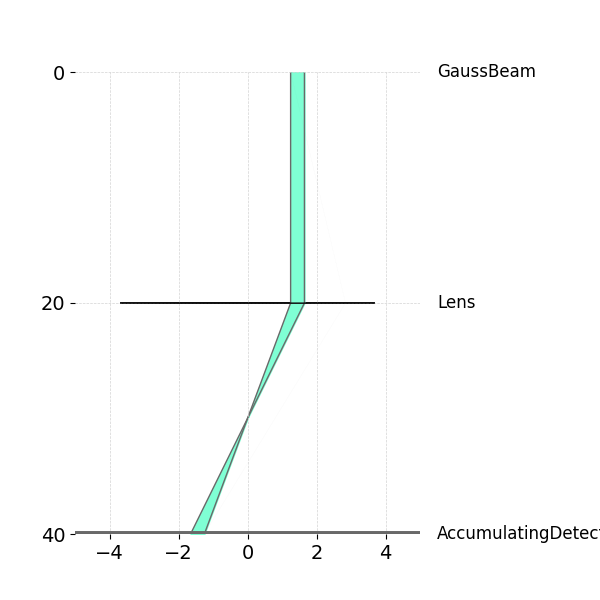

In [17]:
fig, ax = plot_model(model)

In [18]:
end_rays = rays[-1].data[0:4, :].T
path_length = rays[-1].path_length[0::5]

split_end_rays = np.split(end_rays, n_rays, axis=0)
split_path_length = np.split(path_length, n_rays, axis=0)

rayset1 = np.stack(split_end_rays, axis=-1)

xEnd, yEnd = rayset1[0, 0], rayset1[0, 2]
lEnd, mEnd = rayset1[0, 1], rayset1[0, 3]

In [19]:
#get misalignment vectors
x1m = rays[1].data[0, 0::5]
phi_x1m = rays[0].data[1, 0::5]
y1m = rays[1].data[2, 0::5]
phi_y1m = rays[0].data[3, 0::5]

x2m = rays[-2].data[0, 0::5]
phi_x2m = rays[-2].data[1, 0::5]
y2m = rays[-2].data[2, 0::5]
phi_y2m = rays[-2].data[3, 0::5]

r1m = np.array([x1m - x0, y1m - y0]).T
p1m = np.array([phi_x1m, phi_y1m]).T
r2m = np.array([x2m - xEnd, y2m - yEnd]).T
p2m = np.array([phi_x2m, phi_y2m]).T

In [20]:
r2 = make_detector_for_gauss_rays(x_det, x_det, n_rays)
r = r2.copy()

r[:, :,  0] = r2[:, :,  0] - xEnd
r[:, :,  1] = r2[:, :,  1] - yEnd

In [21]:
# A, B, C, D = gbd.differential_matrix(rayset1, dPx, dPy, dHx, dHy)

In [22]:
# Qinv = gbd.calculate_Qinv(z_r)
# Qpinv = gbd.calculate_Qpinv(A, B, C, D, Qinv)
# field = gbd.propagate_misaligned_gaussian(Qinv, Qpinv, r, r1m, p1m, r2m, p2m, r2, k, A, B, path_length).reshape(det_shape)

In [23]:
x = np.linspace(-dsize / 2, dsize / 2, size)
x, y = np.meshgrid(x, x)
dcoords = np.asarray([x.ravel(), y.ravel(), 0 * np.ones_like(x.ravel())])

field = np.zeros(det_shape[-1], dtype=np.complex128)

xEnd, yEnd, dxEnd, dyEnd = rayset1[:, 0], rayset1[:, 2], rayset1[:, 1], rayset1[:, 3]
zEnd  = np.array([0  * np.ones(n_rays * 5)]).T
lEnd, mEnd, nEnd = gbd.convert_slope_to_direction_cosines(dxEnd, dyEnd)

r_ray_end = np.stack((xEnd, yEnd, zEnd), axis = -1)
k_ray_end = np.stack((lEnd, mEnd, nEnd), axis = -1)

mean_base = np.mean(r_ray_end[0, :, :], axis = 0)

# construct orthogonal transformation
O = gbd.orthogonal_transformation_matrix(k_ray_end[0], np.array([0, 0, 1]))

# get ray positions
Delta = gbd.distance_to_transversal(dcoords, r_ray_end, k_ray_end)

# propagate rays to transversal plane and orthogonal transform
r_ray, k_ray = gbd.propagate_rays_and_transform(r_ray_end, k_ray_end, Delta, O)


A = gbd.differential_matrix_calculation(r_ray[0,...,0,0],r_ray[0,...,1,0], # central ray central_u,v
                                        r_ray[1,...,0,0],r_ray[1,...,1,0], # waist_x diff_uu,uv
                                        r_ray[2,...,0,0],r_ray[2,...,1,0], # waist_y diff_vu,vv
                                        dPx,dPy)

C = gbd.differential_matrix_calculation(k_ray[0,...,0,0],k_ray[0,...,1,0], # central ray central_u,v
                                        k_ray[1,...,0,0],k_ray[1,...,1,0], # waist_x diff_uu,uv
                                        k_ray[2,...,0,0],k_ray[2,...,1,0], # waist_y diff_vu,vv
                                        dPx,dPy)

B = gbd.differential_matrix_calculation(r_ray[0,...,0,0],r_ray[0,...,1,0], # central ray central_u,v
                                        r_ray[3,...,0,0],r_ray[3,...,1,0], # diverge_x diff_uu,uv
                                        r_ray[4,...,0,0],r_ray[4,...,1,0], # diverge_y diff_vu,vv
                                        dHx,dHy)

D = gbd.differential_matrix_calculation(k_ray[0,...,0,0],k_ray[0,...,1,0], # central ray central_u,v
                                        k_ray[3,...,0,0],k_ray[3,...,1,0], # diverge_x diff_uu,uv
                                        k_ray[4,...,0,0],k_ray[4,...,1,0], # diverge_y diff_vu,vv
                                        dHx,dHy)

# center pixels on transversal plane
r = gbd.center_transversal_plane(dcoords, r_ray, O)

Qpinv = gbd.propagate_qpinv_abcd(Qinv, A, B, C, D)
Amplitude = np.abs(1 / (np.sqrt(gbd.det_2x2(A + B @ Qinv))))

transversal = gbd.transversal_phase(Qpinv, r, k)
opticalpath = gbd.optical_path_and_delta(path_length, Delta, k)
guoy = gbd.guoy_phase(Qpinv)

field = np.sum(Amplitude * (transversal * opticalpath * guoy), axis=1).reshape(det_shape)
field = zero_phase(field, size//2, size//2)

**Gaussian Beam Propagation**

Text(0.5, 0.98, 'GBP')

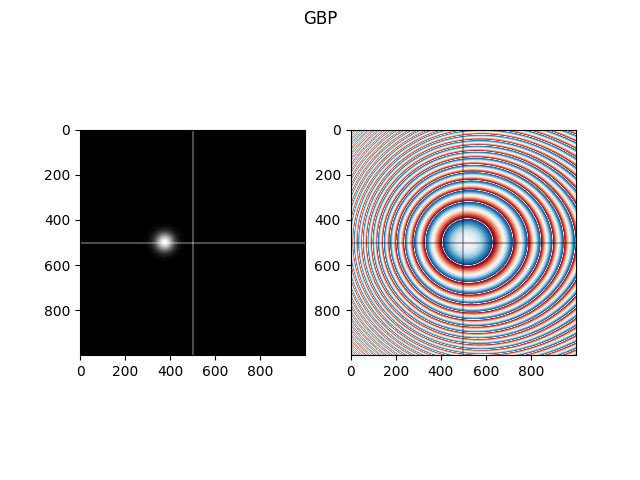

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(field),cmap='gray')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.imshow(np.angle(field),cmap='RdBu')
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("GBP")

**Rayleigh Sommerfeld Propagation**

In [25]:
from diffractio import degrees
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.scalar_masks_XY import Scalar_mask_XY

# Calculate theta and phi
tan_theta_x = np.tan(deg_yx[1])
tan_theta_y = np.tan(deg_yx[0])

theta = np.arctan(np.sqrt(tan_theta_x**2 + tan_theta_y**2))
phi = np.arctan2(tan_theta_y, tan_theta_x)

u1 = Scalar_source_XY(x=x_det, y=x_det, wavelength = wavelength)
u1.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
t1 = Scalar_mask_XY(x=x_det, y=x_det, wavelength = wavelength)
t1.lens(r0 = (0, 0), radius=0, focal=focal)

#If you just want the gaussian at some z, for example z = 10
u1 = u1.RS(z=a)
u2 = u1 * t1
u3 = u2.RS(z=b)

single_gaussian = u3.u
single_gaussian = zero_phase(single_gaussian, size//2, size//2)


Text(0.5, 0.98, 'DiffIO')

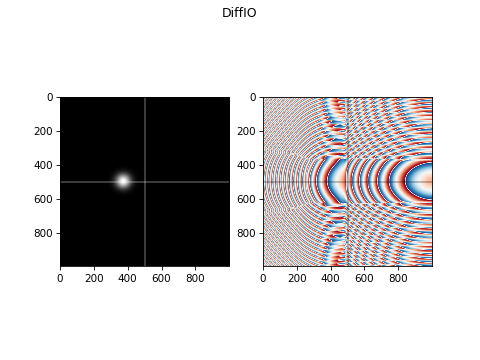

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.abs(single_gaussian), cmap='gray')
ax2.imshow(np.angle(single_gaussian),cmap='RdBu')
ax1.axvline(size // 2, color='white', alpha=0.3)
ax1.axhline(size // 2, color='white', alpha=0.3)
ax2.axvline(size // 2, color='k', alpha=0.3)
ax2.axhline(size // 2, color='k', alpha=0.3)
fig.suptitle("DiffIO")

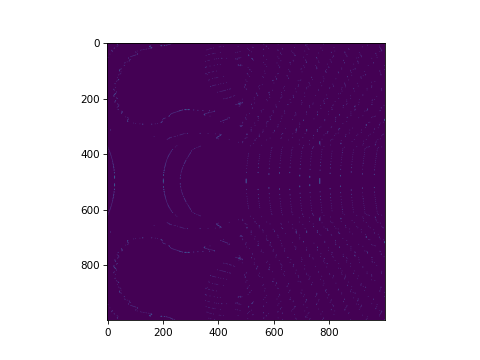

In [27]:
fig, ax1 = plt.subplots()
ax1.imshow(
    np.isclose(
        np.angle(single_gaussian),
        np.angle(field),
        atol=0.01,
    )
)

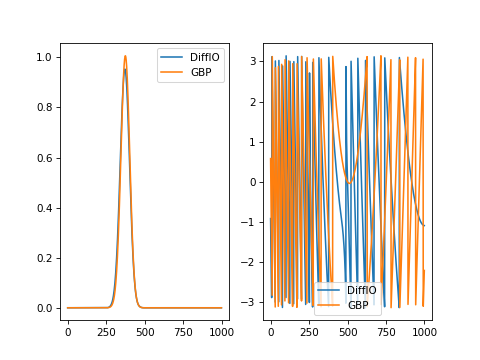

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2)
s = np.s_[size // 2, :]
ax1.plot(np.abs(single_gaussian[s]), label="DiffIO")
ax1.plot(np.abs(field[s]), label="GBP")
ax1.legend()
ax2.plot(np.angle(single_gaussian[s]), label="DiffIO")
ax2.plot(np.angle(field[s]), label="GBP")
ax2.legend()

**FRESNEL Propagation**

In [29]:

u1 = Scalar_source_XY(x=x_det, y=x_det, wavelength=wavelength)
u1.gauss_beam(A=1, r0=(x0, 0), z0=0, w0=(wo, wo), theta=theta, phi=phi)
u1 = FresnelPropagator(u1.u, pixel_size, wavelength, a)
u2 = u1 * lens_phase_factor(size, pixel_size, wavelength, focal)
u3 = FresnelPropagator(u2, pixel_size, wavelength, b)

u3 = zero_phase(u3, size//2, size//2)

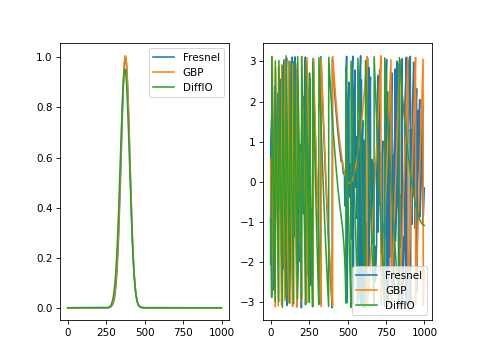

In [30]:

fig, (ax1, ax2) = plt.subplots(1, 2)
s = np.s_[size // 2, :]
ax1.plot(np.abs(u3[s]), label="Fresnel")
ax1.plot(np.abs(field[s]), label="GBP")
ax1.plot(np.abs(single_gaussian[s]), label="DiffIO")
ax1.legend()
ax2.plot(np.angle(u3[s]), label="Fresnel")
ax2.plot(np.angle(field[s]), label="GBP")
ax2.plot(np.angle(single_gaussian[s]), label="DiffIO")
ax2.legend()